In [1]:
] activate ../../Acceleration

 Activating environment at `~/Desktop/Code/Acceleration/Acceleration/Project.toml`


In [2]:
using Acceleration

In [11]:
using LinearAlgebra

data, labels = load_libsvm_dataset("mushrooms",500); # dataset name (a5a, mushrooms), num samples
f,∇f,∇ϕ_cjg,σ,L,μ  = logistic_regression(data,labels,1);

k = 1000
n = size(data,2)
x_ini = zeros(n)
μ = 1
L = 1000

A = data;
b = labels;

m = 20
θ = 1/m


function random_sparsification(x)
    grad = x
    n = size(grad,1)
    r = 1/4
    mask = Float64.(rand(n) .< r)
    rs_gradient = (1/r)*grad.*mask
    return rs_gradient, norm(rs_gradient,2)
end

function dithering(x)
    q = Inf;
    grad = x
    n = size(grad,1)
    levels = 10;
    leveled_gradient = sign.(grad).*(levels/norm(grad,q)).*grad/2
    base = floor.(leveled_gradient)
    rv = Float64.(rand(n) .> (leveled_gradient .- floor.(leveled_gradient)))
    quantized_gradient = sign.(grad).*(base .+ rv)*norm(grad,q)/levels*2;
    
    return quantized_gradient, norm(quantized_gradient,2)
end

function natural_compression(x)
    grad = x
    n = size(grad,1)
    nat_grad = sign.(grad).*2.0.^(floor.(log2.(abs.(grad)))).*(1 .+ rand(n))
    
    return nat_grad, norm(nat_grad,2)
end



function dist_f(x)
    
    sample_size = Int16(floor(size(A,1)/m)) 
    num_features = size(A,2)
    
    sumf = 0;
    
    for j=1:m
        index1 = (j-1)*sample_size + 1;
        index2 = j*sample_size;
        Aj = A[index1:index2,:];
        bj = b[index1:index2];
        sumf = sumf + sum(log.(1 .+ exp.(-bj.*(Aj*x)))) + (θ/2)*norm(x,2)^2
    end
    
    return sumf + (θ/2)*norm(x,2)^2
end

function exact_gradient(x)
    return ∇f(x), 0
end



function distributed_gradient(x)

    sample_size = Int16(floor(size(A,1)/m)) 
    num_features = size(A,2)

    gradients = zeros(m,num_features)

    for j=1:m
        index1 = (j-1)*sample_size + 1;
        index2 = j*sample_size;
        Aj = A[index1:index2,:];
        bj = b[index1:index2];
        grad  = ((exp.(-bj.*Aj*x) ./ (1 .+ exp.(-bj.*Aj*x)) )'*(-bj.*Aj))'[:,1] + θ*x;
        gradients[j,:] = grad
    end 
    
    return sum(gradients,dims=1)'[:,1] + θ*x,0;
end

ω = 0;
grad_fun = distributed_gradient
ff = dist_f

@time f_opt = ufom(ff,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,10*k,Inf)[end]
    
@time p1 = MD(ff,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p2 = PGD_avg(ff,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p3 = ufom(ff,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,Inf) .- f_opt;
@time p4 = AMD_plus(ff,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p5 = μAMD_plus(ff,grad_fun,∇ϕ_cjg,x_ini,L,μ,k) .- f_opt;
@time p6 = ACGD(ff,grad_fun,x_ini,L,k,ω) .- f_opt;
@time p7 = μACGD(ff,grad_fun,x_ini,L,μ,k,ω) .- f_opt;
@time p8 = Nesterov83(ff,grad_fun,x_ini,k) .- f_opt;

┌ Info: Loading dataset mushrooms with 500 samples (out ouf 8124) and 112 features
└ @ Acceleration /Users/victor/Desktop/Code/Acceleration/Acceleration/src/libsvm_datasets.jl:25


  8.465164 seconds (14.10 M allocations: 22.830 GiB, 31.68% gc time)
  0.893055 seconds (1.42 M allocations: 2.277 GiB, 28.28% gc time)
  0.852302 seconds (1.42 M allocations: 2.276 GiB, 28.31% gc time)
  0.815251 seconds (1.40 M allocations: 2.283 GiB, 32.61% gc time)
  0.871080 seconds (1.43 M allocations: 2.280 GiB, 28.73% gc time)
  0.832150 seconds (1.45 M allocations: 2.285 GiB, 31.28% gc time)
  0.810715 seconds (1.44 M allocations: 2.282 GiB, 31.90% gc time)
  0.814937 seconds (1.44 M allocations: 2.282 GiB, 31.96% gc time)
  0.823826 seconds (1.49 M allocations: 2.284 GiB, 30.70% gc time)


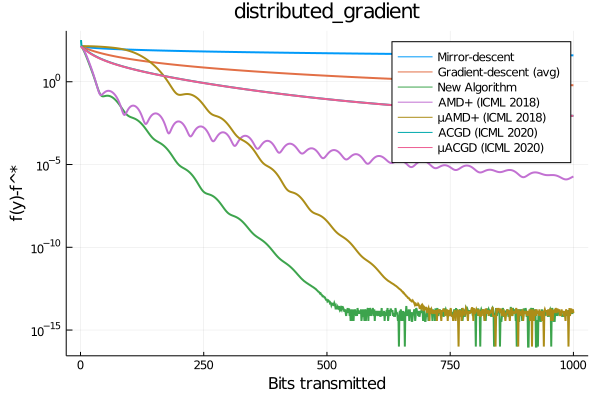

In [12]:
using Plots
fig = plot(max.(min.(hcat(p1,p2,p3,p4,p5,p6,p7),1e3),1e-16),yaxis=:log, linewidth=2, legend=:topright,
label = ["Mirror-descent" "Gradient-descent (avg)" "New Algorithm" "AMD+ (ICML 2018)" "μAMD+ (ICML 2018)" "ACGD (ICML 2020)" "μACGD (ICML 2020)" "AGD (Nesterov)"], title=grad_fun, xlabel = "Bits transmitted", ylabel = "f(y)-f^*")

In [24]:
function distributed_gradient_exact(x)

    sample_size = Int16(floor(size(A,1)/m)) 
    num_features = size(A,2)

    gradients = zeros(m,num_features)

    for j=1:m
        index1 = (j-1)*sample_size + 1;
        index2 = j*sample_size;
        Aj = A[index1:index2,:];
        bj = b[index1:index2];
        grad  = ((exp.(-bj.*Aj*x) ./ (1 .+ exp.(-bj.*Aj*x)) )'*(-bj.*Aj))'[:,1] + θ*x;
        gradients[j,:] = grad
    end 
    
    return sum(gradients,dims=1)'[:,1] + θ*x,0;
end

function distributed_gradient_natural(x)

    sample_size = Int16(floor(size(A,1)/m)) 
    num_features = size(A,2)

    gradients = zeros(m,num_features)

    for j=1:m
        index1 = (j-1)*sample_size + 1;
        index2 = j*sample_size;
        Aj = A[index1:index2,:];
        bj = b[index1:index2];
        grad  = ((exp.(-bj.*Aj*x) ./ (1 .+ exp.(-bj.*Aj*x)) )'*(-bj.*Aj))'[:,1] + θ*x;
        n = size(grad,1)
        nat_grad = sign.(grad).*2.0.^(floor.(log2.(abs.(grad)))).*(1 .+ rand(n))
        gradients[j,:] = nat_grad
    end 
    
    return sum(gradients,dims=1)'[:,1] + θ*x,0;
end

function distributed_gradient_rand(x)

    sample_size = Int16(floor(size(A,1)/m)) 
    num_features = size(A,2)

    gradients = zeros(m,num_features)

    for j=1:m
        index1 = (j-1)*sample_size + 1;
        index2 = j*sample_size;
        Aj = A[index1:index2,:];
        bj = b[index1:index2];
        grad  = ((exp.(-bj.*Aj*x) ./ (1 .+ exp.(-bj.*Aj*x)) )'*(-bj.*Aj))'[:,1] + θ*x;
        n = size(grad,1)
        r = 1/4
        mask = Float64.(rand(n) .< r)
        rs_gradient = (1/r)*grad.*mask
        gradients[j,:] = rs_gradient
    end 
    
    return sum(gradients,dims=1)'[:,1] + θ*x,0;
end

function distributed_gradient_dithering(x)

    sample_size = Int16(floor(size(A,1)/m)) 
    num_features = size(A,2)

    gradients = zeros(m,num_features)

    for j=1:m
        index1 = (j-1)*sample_size + 1;
        index2 = j*sample_size;
        Aj = A[index1:index2,:];
        bj = b[index1:index2];
        grad  = ((exp.(-bj.*Aj*x) ./ (1 .+ exp.(-bj.*Aj*x)) )'*(-bj.*Aj))'[:,1] + θ*x;
        q = Inf;
        n = size(grad,1)
        levels = 10;
        leveled_gradient = sign.(grad).*(levels/norm(grad,q)).*grad/2
        base = floor.(leveled_gradient)
        rv = Float64.(rand(n) .> (leveled_gradient .- floor.(leveled_gradient)))
        quantized_gradient = sign.(grad).*(base .+ rv)*norm(grad,q)/levels*2;
        gradients[j,:] = quantized_gradient
    end 
    
    return sum(gradients,dims=1)'[:,1] + θ*x,0;
end    


distributed_gradient_dithering (generic function with 1 method)

In [ ]:
using Acceleration
using LinearAlgebra

data, labels = load_libsvm_dataset("mushrooms",500); # dataset name (a5a, mushrooms), num samples
f,∇f,∇ϕ_cjg,σ,L,μ  = logistic_regression(data,labels,1);

k = 10
n = size(data,2)
x_ini = zeros(n)
μ = 1
L = 1000

A = data;
b = labels;

m = 20
θ = 1/m


function dist_f(x)
    
    sample_size = Int16(floor(size(A,1)/m)) 
    num_features = size(A,2)
    
    sumf = 0;
    
    for j=1:m
        index1 = (j-1)*sample_size + 1;
        index2 = j*sample_size;
        Aj = A[index1:index2,:];
        bj = b[index1:index2];
        sumf = sumf + sum(log.(1 .+ exp.(-bj.*(Aj*x)))) + (θ/2)*norm(x,2)^2
    end
    
    return sumf + (θ/2)*norm(x,2)^2
end

for model in ["mushrooms"]
    
    data, labels = load_libsvm_dataset(model,1000); # dataset name (a5a, mushrooms), num samples
    f,∇f,∇ϕ_cjg,σ,L,μ  = logistic_regression(data,labels,1);

    d,n = size(data)
    x_ini = zeros(n)
    k = 2000;
    μ = 0.1
    L = 200
    if(model=="a5a")
        L = 1000;
    end
    ω = 0;


    @time f_opt = ufom(dist_f,distributed_gradient_exact,∇ϕ_cjg,x_ini,σ,L,μ,2*k,Inf)[end]

    @time for grad_fun in [distributed_gradient_exact,distributed_gradient_rand, distributed_gradient_dithering, distributed_gradient_natural]

        p3 = max.(1e-12,ufom(dist_f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,Inf) .- f_opt);
        p4 = max.(1e-12,AMD_plus(dist_f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt);
        p7 = max.(1e-12,μACGD(dist_f,grad_fun,x_ini,L,μ,k,ω) .- f_opt);
    
        filename = string("logs/",model,"_",grad_fun,".txt")
        io = open(filename, "w")
        
        if(grad_fun==distributed_gradient_exact)
            bits = n*64;
        elseif(grad_fun==distributed_gradient_rand)
            bits = (n/4)*64;
        elseif(grad_fun==distributed_gradient_dithering)
            bits = 2.8*n + 64;
        elseif(grad_fun==distributed_gradient_natural)
            bits = n*9;
        end
        
        for i=1:k
            print(io,i)
            print(io,"\t")
            print(io,i*n*64)
            print(io,"\t")
            print(io,i*bits)
            print(io,"\t")
            print(io, p7[i])
            print(io,"\t")
            print(io, p4[i])
            print(io,"\t")
            print(io, p3[i])
            print(io,"\n")
        end
        close(io)
    end
end

┌ Info: Loading dataset mushrooms with 500 samples (out ouf 8124) and 112 features
└ @ Acceleration /Users/victor/Desktop/Code/Acceleration/Acceleration/src/libsvm_datasets.jl:25
┌ Info: Loading dataset mushrooms with 1000 samples (out ouf 8124) and 112 features
└ @ Acceleration /Users/victor/Desktop/Code/Acceleration/Acceleration/src/libsvm_datasets.jl:25
